In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

# Load full dataset
file_path = '/content/Online Retail.xlsx'
df = pd.read_excel(file_path, sheet_name='Online Retail', engine='openpyxl')

# Step 1: Handle missing values
df.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Step 2: Remove duplicates
df.drop_duplicates(inplace=True)

# Step 3: Validate numeric columns (remove invalid values)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Step 4: Create a TotalPrice column for analysis
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Drop unnecessary columns
df.drop(columns=['InvoiceNo', 'StockCode', 'InvoiceDate', 'Country'], inplace=True)

# Select numeric columns for standardization
numeric_columns = ['Quantity', 'UnitPrice', 'TotalPrice']
data_numeric = df[numeric_columns]

# Step 5: Standardize numeric data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Step 6: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for simplicity
data_pca = pca.fit_transform(data_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])

# Display PCA explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Save the preprocessed data and PCA results
preprocessed_data = pd.concat([df.reset_index(drop=True), pca_df], axis=1)
preprocessed_data.to_csv('Preprocessed_Online_Retail.csv', index=False)


<ipython-input-4-7f8b757ab9ca>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
<ipython-input-4-7f8b757ab9ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['InvoiceNo', 'StockCode', 'InvoiceDate', 'Country'], inplace=True)


Explained Variance Ratio: [0.63923057 0.3336036 ]


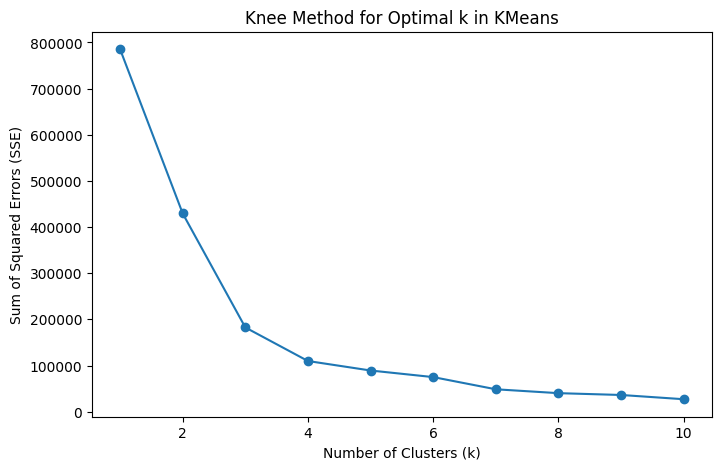

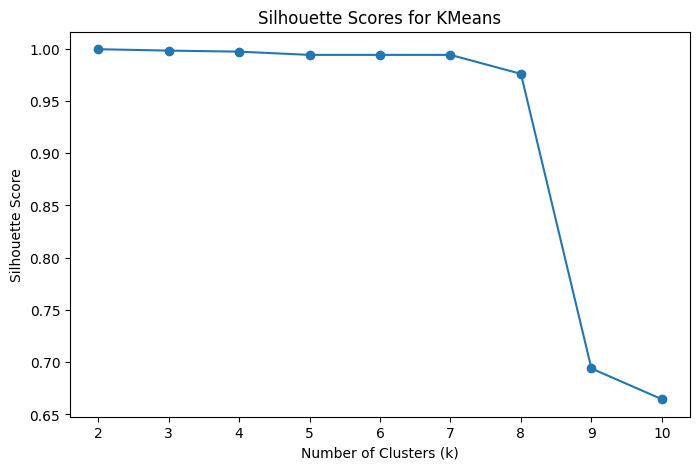

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Load the dataset
data = pd.read_csv('/content/Preprocessed_Online_Retail.csv')

# Select the PCA1 and PCA2 columns for clustering
features = data[['PCA1', 'PCA2']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 1: Visualize the Knee for KMeans clustering
sse = []
k_values = range(1, 11)  # Evaluate for k=1 to k=10

def compute_kmeans_sse(k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    return kmeans.inertia_

sse = Parallel(n_jobs=-1)(delayed(compute_kmeans_sse)(k) for k in k_values)

# Plot the elbow (knee) curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.title('Knee Method for Optimal k in KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

# Step 2: Silhouette scores for KMeans clustering
silhouette_scores = []

def compute_kmeans_silhouette(k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    return silhouette_score(features_scaled, cluster_labels)

silhouette_scores = Parallel(n_jobs=-1)(delayed(compute_kmeans_silhouette)(k) for k in range(2, 11))

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


Silhouette Score for Hierarchical Clustering: 0.03796355830503225


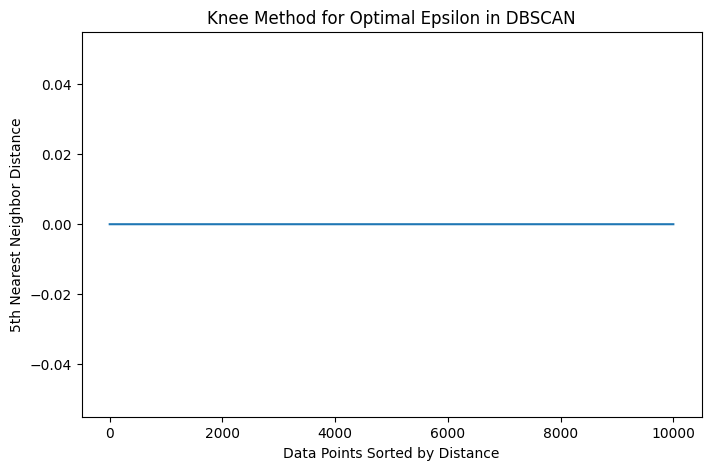

Silhouette Score for DBSCAN: 0.8963043797032204
Calinski-Harabasz Index for KMeans: 648580.853939335
Calinski-Harabasz Index for Hierarchical: 80.87779256583588
Calinski-Harabasz Index for DBSCAN: 4595.000893707426


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Load the dataset
data = pd.read_csv('/content/Preprocessed_Online_Retail.csv')

# Select the PCA1 and PCA2 columns for clustering
features = data[['PCA1', 'PCA2']]

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Hierarchical clustering with memory efficiency
batch_size = 1000  # Process data in chunks to avoid memory overflow
num_samples = features_scaled.shape[0]
hierarchical_labels = np.zeros(num_samples, dtype=int)

for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    hierarchical = AgglomerativeClustering(n_clusters=3)
    hierarchical_labels[start:end] = hierarchical.fit_predict(features_scaled[start:end])

hierarchical_silhouette = silhouette_score(features_scaled, hierarchical_labels)
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}")

# Step 4: DBSCAN clustering with memory efficiency
# Determine the optimal epsilon using Nearest Neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5, n_jobs=-1)
neighbors = nearest_neighbors.fit(features_scaled)
distances, indices = neighbors.kneighbors(features_scaled)
distances = np.sort(distances[:, -1])

# Plot the distances to find the elbow for epsilon
plt.figure(figsize=(8, 5))
plt.plot(distances[:10000])  # Limit plot size to first 10,000 points to avoid memory issues
plt.title('Knee Method for Optimal Epsilon in DBSCAN')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()

# Example DBSCAN with an assumed epsilon value (adjust based on the elbow plot)
batch_size = 1000
dbscan_labels = np.full(features_scaled.shape[0], -1, dtype=int)  # Initialize all labels to -1

def process_dbscan_batch(start, end):
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps based on the above plot
    return dbscan.fit_predict(features_scaled[start:end])

for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    dbscan_labels[start:end] = process_dbscan_batch(start, end)

if len(set(dbscan_labels)) > 1:  # Check if DBSCAN found more than one cluster
    dbscan_silhouette = silhouette_score(features_scaled, dbscan_labels)
    print(f"Silhouette Score for DBSCAN: {dbscan_silhouette}")
else:
    print("DBSCAN did not find enough clusters for Silhouette Score calculation.")

# Step 5: Additional evaluation metrics (e.g., Calinski-Harabasz Index)
kmeans_ch_index = calinski_harabasz_score(features_scaled, KMeans(n_clusters=3, random_state=42).fit_predict(features_scaled))
hierarchical_ch_index = calinski_harabasz_score(features_scaled, hierarchical_labels)
dbscan_ch_index = calinski_harabasz_score(features_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else 'N/A'

print(f"Calinski-Harabasz Index for KMeans: {kmeans_ch_index}")
print(f"Calinski-Harabasz Index for Hierarchical: {hierarchical_ch_index}")
print(f"Calinski-Harabasz Index for DBSCAN: {dbscan_ch_index}")


Dari hasil yang diperoleh, kita dapat menarik kesimpulan sebagai berikut:

1. **K-Means Clustering**:
   - Berdasarkan grafik **Knee Method**, nilai optimal jumlah cluster adalah sekitar 3, karena terlihat adanya elbow yang jelas pada k = 3.
   - **Silhouette Score** menunjukkan nilai yang tinggi (>0.95) hingga k = 7, namun mulai turun drastis setelahnya.
   - **Calinski-Harabasz Index** untuk K-Means adalah **648,580.85**, nilai yang sangat tinggi, menunjukkan kualitas cluster yang baik.

2. **Hierarchical Clustering**:
   - Silhouette Score untuk hierarchical clustering adalah **0.03796**, yang sangat rendah, menunjukkan bahwa clustering ini tidak memberikan pembagian cluster yang baik untuk dataset.
   - **Calinski-Harabasz Index** untuk hierarchical clustering adalah **80.88**, jauh lebih rendah dibandingkan K-Means dan DBSCAN, menunjukkan kualitas clustering yang buruk.

3. **DBSCAN Clustering**:
   - Silhouette Score untuk DBSCAN adalah **0.8963**, cukup tinggi, yang menunjukkan bahwa pembagian cluster oleh DBSCAN lebih baik dibandingkan hierarchical clustering, meskipun sedikit lebih rendah dibandingkan K-Means.
   - **Calinski-Harabasz Index** untuk DBSCAN adalah **4,595.00**, yang jauh lebih rendah dibandingkan K-Means namun lebih baik dibandingkan hierarchical clustering.

### Kesimpulan Akhir:
- Berdasarkan **Silhouette Score** dan **Calinski-Harabasz Index**, model **K-Means Clustering** dengan jumlah cluster optimal k=3 adalah model terbaik untuk dataset ini.
- DBSCAN dapat menjadi alternatif, terutama jika dataset memiliki struktur atau distribusi data yang tidak linear, tetapi performanya sedikit kalah dengan K-Means.
- Hierarchical clustering tidak cocok untuk dataset ini, karena memiliki skor evaluasi yang sangat rendah.
